<a href="https://colab.research.google.com/github/denny0323/LabelCorruption/blob/main/DFL_Siamese_pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os
path = '/content/drive/MyDrive/Colab Notebooks/'
sys.path.append(path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

from util_SB import *
from modelDFL import *

In [ ]:
batch_size = 256
test_batch_size = 100

NOISE_LEVEL= 0.000

train_set = WBMs(pkl_dir=path, train=True)
test_set = WBMs(pkl_dir=path, train=False)

train_set_siamese = WBMsSiamese_standard(train_set)
test_set_siamese = WBMsSiamese_standard(test_set)

train_loader = DataLoader(train_set_siamese, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set_siamese, batch_size=test_batch_size, shuffle=False)

In [ ]:
epochs = 400

net = SiameseNet().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 4e-4)

counter = []
loss_history = [] 
prog_iter = 0
best_acc = 0
cont = 0

num_iter = (len(train_loader.dataset)//batch_size)+1

In [ ]:
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

WBMs:0.00-symm | Epoch [  1/400] Iter[ 14/ 14] Train_loss: 0.3420 | Test_loss: 0.3942 | acc: 0.41 | best_acc: 0.59
WBMs:0.00-symm | Epoch [  2/400] Iter[ 14/ 14] Train_loss: 0.3367 | Test_loss: 0.3698 | acc: 0.50 | best_acc: 0.59
WBMs:0.00-symm | Epoch [  3/400] Iter[ 14/ 14] Train_loss: 0.3172 | Test_loss: 0.2887 | acc: 0.67 | best_acc: 0.70
WBMs:0.00-symm | Epoch [  4/400] Iter[ 14/ 14] Train_loss: 0.3130 | Test_loss: 0.2663 | acc: 0.72 | best_acc: 0.78
WBMs:0.00-symm | Epoch [  5/400] Iter[ 14/ 14] Train_loss: 0.2449 | Test_loss: 0.2372 | acc: 0.72 | best_acc: 0.78
WBMs:0.00-symm | Epoch [  6/400] Iter[ 14/ 14] Train_loss: 0.2399 | Test_loss: 0.2323 | acc: 0.83 | best_acc: 0.81
WBMs:0.00-symm | Epoch [  7/400] Iter[ 14/ 14] Train_loss: 0.2075 | Test_loss: 0.2856 | acc: 0.67 | best_acc: 0.87
WBMs:0.00-symm | Epoch [  8/400] Iter[ 14/ 14] Train_loss: 0.1783 | Test_loss: 0.2001 | acc: 0.78 | best_acc: 0.87
WBMs:0.00-symm | Epoch [  9/400] Iter[ 14/ 14] Train_loss: 0.1875 | Test_loss: 0

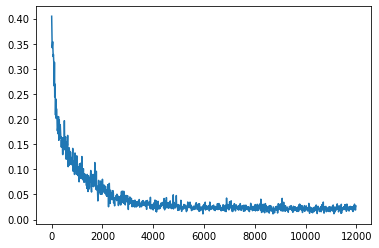

In [ ]:
for epoch in range(1, epochs+1):
    for batch_idx, data in enumerate(train_loader):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda() , label.cuda()

        optimizer.zero_grad()

        output1, output2 = net(img0, img1)

        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0 or batch_idx+1 == num_iter:

            counter.append(prog_iter)
            loss_history.append(loss.item())
            prog_iter += 10
            
            for _, test_data in enumerate(test_loader):
                test1, test2, label_test = test_data
                test1, test2, label_test = test1.cuda(), test2.cuda(), label_test.cuda()
                
                output1_test, output2_test = net.forward(test1, test2)
                test_loss = criterion(output1_test, output2_test, label_test)
                dist = F.pairwise_distance(output1_test, output2_test, keepdim = True)
                pred = dist < 0.5
                acc = torch.sum(pred == label_test).item()/test1.size()[0]
            
                sys.stdout.write('\r')
                sys.stdout.write('%s:%.2f-%s | Epoch [%3d/%3d] Iter[%3d/%3d] Train_loss: %.4f | Test_loss: %.4f | acc: %.2f | best_acc: %.2f'
                        %('WBMs', train_set.NOISE_LEVEL, train_set.noise_mode, epoch, epochs, batch_idx+1, num_iter, 
                         loss.item(), test_loss.item(), acc, best_acc))
                #sys.stdout.write('%s:%.2f-%s | Epoch [%3d/%3d] Iter[%3d/%3d] Train_loss: %.4f'
                #        %('WBMs', train_set.NOISE_LEVEL, train_set.noise_mode, epoch, epochs, batch_idx+1, num_iter, loss.item()))
                sys.stdout.flush()


        if batch_idx+1 == num_iter:
            sys.stdout.write('\n')
        
#         if acc > best_acc:
#             best_acc = acc
#             directory = './preSiamese'
#             os.makedirs(directory, exist_ok=True)
#             
#             if cont>0:
#                 try:
#                     os.remove(os.path.join(directory, snapBest + '.pth'))
#                     os.remove(os.path.join(directory, 'opt_' + snapBest + '.pth'))
#                 except OSError:
#                     pass         
#             
#             snapBest = 'Pretrain_best_epoch_%d_valLoss_%.5f_valAcc_%.5f_noise_%.2f_bestAccVal_%.5f' % (
#                     epoch, test_loss, acc, NOISE_LEVEL, best_acc)  
#             
#             torch.save(net.state_dict(), os.path.join(directory, snapBest + '.pth'))
#             torch.save(optimizer.state_dict(), os.path.join(directory, 'opt_' + snapBest + '.pth'))
            
            
        if epoch == 1:
            best_acc = acc
            snapBest = 'Pretrain_best_epoch_%d_valLoss_%.5f_valAcc_%.5f_noise_%.2f_bestAccVal_%.5f' % (
                    epoch, test_loss, acc, NOISE_LEVEL, best_acc) 
            
            directory = path+'preSiamese'
            os.makedirs(directory, exist_ok=True)
            torch.save(net.state_dict(), os.path.join(directory, snapBest + '.pth'))
            #torch.save(optimizer.state_dict(), os.path.join(directory, 'opt_' + snapBest + '.pth'))
            #print('└ save the best model in {}/{}\n'.format(directory, snapBest+'.pth')) 

        else:
            if acc >= best_acc:
                best_acc = acc

                if cont>0:
                    # os.remove(os.path.join(directory, 'opt_' + snapBest + '.pth'))
                    os.remove(os.path.join(directory, snapBest + '.pth'))
                    
                snapBest = 'Pretrain_best_epoch_%d_valLoss_%.5f_valAcc_%.5f_noise_%.2f_bestAccVal_%.5f' % (
                    epoch, test_loss, acc, NOISE_LEVEL, best_acc)  
                
                torch.save(net.state_dict(), os.path.join(directory, snapBest + '.pth'))
                #torch.save(optimizer.state_dict(), os.path.join(directory, 'opt_' + snapBest + '.pth'))

        cont+=1

            
show_plot(counter, loss_history)

In [ ]:
snapBest

'Pretrain_best_epoch_192_valLoss_0.08648_valAcc_0.96296_noise_0.00_bestAccVal_0.96296'

In [ ]:
! ls

drive  sample_data
